In [1]:
# Plot ad hoc CIFAR10 instances
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2gray

In [2]:
# Running on an Quadro RTX 4000 (Similar to RTX 2070) Set memory limit else it is out of memory
gpus= tf.config.list_physical_devices('GPU') 
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## (a)

In [3]:
# load data
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
# create a grid of 3x3 images

print(y_train.shape)
index_bird_train = np.where(y_train == 2)
index_bird_test = np.where(y_test == 2)

(50000, 1)


## (b)

In [4]:
X_train = X_train[index_bird_train[0]]
y_train = y_train[index_bird_train[0]]
X_test = X_test[index_bird_test[0]]
y_test = y_test[index_bird_test[0]]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# X_train = np.append(X_train,X_test,axis=0)
# y_train = np.append(y_train,y_test,axis=0)

(5000, 32, 32, 3)
(5000, 1)
(1000, 32, 32, 3)
(1000, 1)


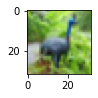

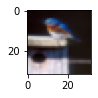

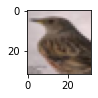

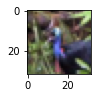

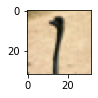

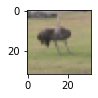

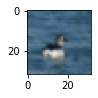

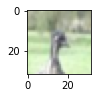

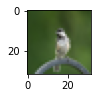

In [5]:
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
    plt.show()

## (c)

I would select all the pixels in K-mean (P = 6144000)

## (d)
In this section, I first run k-means clustering on a single image to test the algorithm. Then I run k-means clustering on all (6144000) pixels.

In [6]:
class KMeans:
    def __init__(self, n_cluster, max_iter=100, e=0.0001):
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.e = e
    
    def fit_opt(self, x):
        np.random.seed(42)
        N, D = x.shape
        centroids = x[np.random.choice(len(x), self.n_cluster)]
        gamma = np.zeros(N)
        sse = None
        
        for i in range(self.max_iter):
            # Assign each data point to nearest centroid
            distance = ((np.reshape(x, (N, 1, D)) -  centroids) ** 2).sum(axis=2)
            gamma = np.argmin(distance, axis=1)
            
            # Computer SSE to check for convergence
            sse_new = ((x - centroids[gamma.astype(int)]) ** 2).sum() / N
            if sse is None:
                sse = sse_new
            elif abs(sse_new - sse) < self.e:
                break
            else:
                sse = sse_new
            
            # Compute new centroids as mean of data points in each cluster
            centroids_new = np.zeros((self.n_cluster, D))

            for centroid_ind in range(self.n_cluster):
                cluster_data = x[gamma == centroid_ind]
                if(cluster_data.size != 0):
                    centroids_new[centroid_ind] = cluster_data.mean(axis=0)
                else:
                    centroids_new[centroid_ind] = centroids[np.random.randint(self.n_cluster, size=1)]
                
            centroids = centroids_new
            
        return centroids, i + 1

In [7]:
def get_k_means_plus_plus_center_indices(n, n_cluster, x, generator=np.random):
    '''
    :param n: number of samples in the data
    :param n_cluster: the number of cluster centers required
    :param x: data - numpy array of points
    :param generator: random number generator. Use it in the same way as np.random.

    :return: the center points array of length n_clusters with each entry being the *index* of a sample
             chosen as centroid.
    '''
    centers = []
    initial = generator.randint(0, n)
    centers.append(initial)
    prob = np.zeros(n)
    for k in range(1, n_cluster):
        i = 0
        for data in x:
            prob[i] = np.min([float(np.linalg.norm(data - x[centers[j]]) ** 2) for j in range(k)])
            i += 1
        prob = prob / sum(prob)
        r = generator.rand()
        m = 0
        while r > 0:
            r -= prob[m]
            m += 1
        centers.append(m - 1)
    return centers

In [8]:
im = X_train[0].copy()

In [9]:
def transform_image(image, centroids):
    N, M = image.shape[:2]
    distances = ((np.reshape(image, (N, M, 1, 3)) - centroids) ** 2).sum(axis = 3)
    centroid_indices = np.argmin(distances, axis=2)
    
    return centroids[centroid_indices]

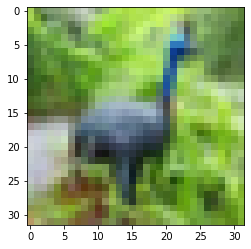

In [10]:
plt.imshow(im)

In [11]:
im.astype(np.float32)

array([[[164., 206.,  84.],
        [105., 140.,  61.],
        [118., 148., 101.],
        ...,
        [109., 147.,  73.],
        [108., 147.,  69.],
        [ 91., 129.,  57.]],

       [[167., 213.,  84.],
        [116., 160.,  49.],
        [ 72., 109.,  43.],
        ...,
        [105., 142.,  79.],
        [105., 142.,  72.],
        [ 89., 127.,  57.]],

       [[140., 191.,  65.],
        [142., 193.,  66.],
        [119., 163.,  79.],
        ...,
        [104., 139.,  84.],
        [ 84., 120.,  58.],
        [ 78., 115.,  49.]],

       ...,

       [[139., 148.,  81.],
        [142., 155.,  74.],
        [135., 156.,  72.],
        ...,
        [ 89., 134.,  28.],
        [ 97., 148.,  24.],
        [126., 176.,  49.]],

       [[163., 157.,  85.],
        [153., 164.,  82.],
        [146., 164.,  90.],
        ...,
        [ 85., 130.,  19.],
        [ 98., 148.,  27.],
        [127., 178.,  48.]],

       [[183., 153., 102.],
        [176., 182., 116.],
        [154., 1

Centroids computed in 18 iterations
[[123.1396648  165.36871508  65.46368715]
 [ 73.92068966  96.45517241  48.47241379]
 [ 97.36666667 122.65555556 132.21111111]
 [171.81818182 204.1013986  132.98951049]]
Mean square error: 1716.2329406769077



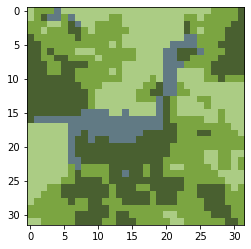

In [12]:
N, M = im.shape[:2]
data = im.reshape(N * M, 3)
k = 4

k_means = KMeans(k, 1000, 1e-6)
centroids, i = k_means.fit_opt(data)

print('Centroids computed in {} iterations'.format(i))
print(centroids)
im_comp = transform_image(im, centroids)

mse = np.sum((im - im_comp) ** 2) / (N * M)
print('Mean square error: {}\n'.format(mse))

plt.imshow(im_comp.astype(int))

In [13]:
centroids.astype(np.uint8)

array([[123, 165,  65],
       [ 73,  96,  48],
       [ 97, 122, 132],
       [171, 204, 132]], dtype=uint8)

In [14]:
colorful_centroids = np.array([[0,0,128], [230, 25, 75], [170, 255, 195], [255, 255, 255]])

Mean square error: 19307.0712890625



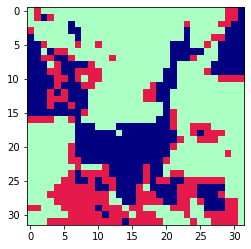

In [15]:
im_colorful = transform_image(im, colorful_centroids)

mse = np.sum((im - im_colorful) ** 2) / (N * M)
print('Mean square error: {}\n'.format(mse))

plt.imshow(im_colorful.astype(int))

Note that since I selected all the pixels, it would take a relatively long time to compute. So I store the pre-computed value to accelerate the debugging process. The computation code is commented above

In [16]:
#X = np.append(X_train,X_test,axis=0)
#N, M, L = X.shape[:3]
#data = X.reshape(N * M * L, 3)
#centroids, _ = k_means.fit_opt(data)
centroids = np.array([[108, 108,  82],[156, 155, 135],[ 48,  49,  38],[206, 211, 211]])
'''
centroids = np.array([[ 14,  14,  12], [190, 174, 133],
       [ 49,  55,  53],
       [156, 156, 149],
       [117, 141,  85],
       [112, 115, 113],
       [ 69,  95,  39],
       [161, 101,  55],
       [218, 201, 160],
       [ 54, 117, 186],
       [224, 223, 217],
       [179, 177, 169],
       [208, 176,  74],
       [ 59,  92, 123],
       [196, 198, 196],
       [137, 136, 127],
       [145, 128,  96],
       [104, 122,  51],
       [171, 147, 112],
       [ 93,  96,  86],
       [109, 138, 165],
       [ 71,  59,  36],
       [152, 173, 104],
       [148, 173, 199],
       [ 73,  75,  68],
       [121, 107,  80],
       [246, 248, 246],
       [103,  83,  54],
       [107, 164, 224],
       [143, 154,  61],
       [173, 206, 237],
       [ 37,  38,  28]])
'''

'\ncentroids = np.array([[ 14,  14,  12], [190, 174, 133],\n       [ 49,  55,  53],\n       [156, 156, 149],\n       [117, 141,  85],\n       [112, 115, 113],\n       [ 69,  95,  39],\n       [161, 101,  55],\n       [218, 201, 160],\n       [ 54, 117, 186],\n       [224, 223, 217],\n       [179, 177, 169],\n       [208, 176,  74],\n       [ 59,  92, 123],\n       [196, 198, 196],\n       [137, 136, 127],\n       [145, 128,  96],\n       [104, 122,  51],\n       [171, 147, 112],\n       [ 93,  96,  86],\n       [109, 138, 165],\n       [ 71,  59,  36],\n       [152, 173, 104],\n       [148, 173, 199],\n       [ 73,  75,  68],\n       [121, 107,  80],\n       [246, 248, 246],\n       [103,  83,  54],\n       [107, 164, 224],\n       [143, 154,  61],\n       [173, 206, 237],\n       [ 37,  38,  28]])\n'

In [17]:
tetrachrome_train = np.empty((X_train.shape), dtype=np.uint8)
tetrachrome_test = np.empty((X_test.shape), dtype=np.uint8)
for i in range(X_train.shape[0]):
    tetrachrome_train[i] = (transform_image(X_train[i], centroids)).astype(np.uint8)
for i in range(X_test.shape[0]):
    tetrachrome_test[i] = (transform_image(X_test[i], centroids)).astype(np.uint8)
    
print(tetrachrome_train.shape)
print(tetrachrome_test.shape)

(5000, 32, 32, 3)
(1000, 32, 32, 3)


In [18]:
centroids.astype(np.uint8)

array([[108, 108,  82],
       [156, 155, 135],
       [ 48,  49,  38],
       [206, 211, 211]], dtype=uint8)

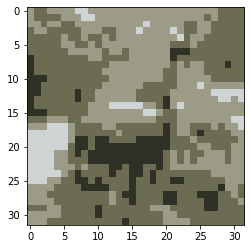

In [19]:
plt.imshow(tetrachrome_train[0])

In [20]:
centroids_encoding = np.identity(k).astype(np.uint8) # identity matrix as encoding
# Calculate the one hot encoded image which is going to be the output of the network. 
def one_hot_encode_image(image, centroids):
    N, M = image.shape[:2]
    distances = ((np.reshape(image, (N, M, 1, 3)) - centroids) ** 2).sum(axis = 3)
    centroid_indices = np.argmin(distances, axis=2)
    
    return centroids_encoding[centroid_indices]

In [21]:
N, M = X_train.shape[1:3]
one_hot_encoded_train = np.empty([X_train.shape[0], N, M, k], dtype=np.uint8)
one_hot_encoded_test = np.empty([X_test.shape[0], N, M, k], dtype=np.uint8)

for i in range(X_train.shape[0]):
    one_hot_encoded_train[i] = (one_hot_encode_image(X_train[i], centroids)).astype(np.uint8)
for i in range(X_test.shape[0]):
    one_hot_encoded_test[i] = (one_hot_encode_image(X_test[i], centroids)).astype(np.uint8)
    
print(one_hot_encoded_train.shape)
print(one_hot_encoded_test.shape)

(5000, 32, 32, 4)
(1000, 32, 32, 4)


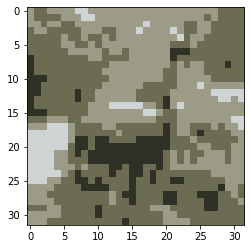

In [22]:
# Check if it is same as above
plt.imshow(np.dot(one_hot_encoded_train[0], centroids.astype(np.uint8)))

In [23]:
one_hot_encoded_train[0].shape

(32, 32, 4)

## (e)

In [24]:
grayscale_img = rgb2gray(im)

In [25]:
(grayscale_img * 255).astype(np.uint8)

array([[188, 126, 138, ..., 133, 133, 115],
       [193, 142,  96, ..., 129, 129, 113],
       [171, 173, 147, ..., 127, 107, 102],
       ...,
       [141, 146, 145, ..., 116, 128, 156],
       [153, 155, 154, ..., 112, 128, 157],
       [155, 175, 150, ..., 117, 116, 150]], dtype=uint8)

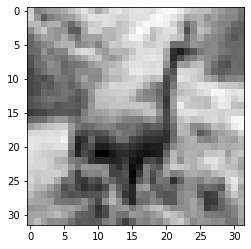

In [26]:
plt.imshow((grayscale_img * 255).astype(np.uint8), cmap=plt.cm.gray)

In [27]:
grayscale_img = rgb2gray(im)

In [28]:
grayscale_train = np.empty((X_train.shape[:3]), dtype=np.uint8)
grayscale_test = np.empty((X_test.shape[:3]), dtype=np.uint8)

In [29]:
print(grayscale_train.shape)
print(grayscale_test.shape)

(5000, 32, 32)
(1000, 32, 32)


In [30]:
for i in range(X_train.shape[0]):
    grayscale_img = rgb2gray(X_train[i])
    grayscale_train[i] = (grayscale_img * 255).astype(np.uint8)
    
for i in range(X_test.shape[0]):
    grayscale_img = rgb2gray(X_test[i])
    grayscale_test[i] = (grayscale_img * 255).astype(np.uint8)

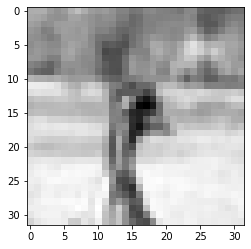

In [31]:
plt.imshow(grayscale_train[7], cmap=plt.cm.gray)

## (f)
This section I used code from the Internet
https://blog.csdn.net/Forrest97/article/details/106136435/
(It is not written in English :-)

In [32]:
from    tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

In [33]:
class CellBlock(layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(CellBlock, self).__init__()

        self.conv1 = Conv2D(filter_num, (3,3), strides=stride, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')

        self.conv2 = Conv2D(filter_num, (3,3), strides=1, padding='same')
        self.bn2 = BatchNormalization()

        if stride !=1:
            self.residual = Conv2D(filter_num, (1,1), strides=stride)
        else:
            self.residual = lambda x:x
        
    def call (self, inputs, training=None):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        r = self.residual(inputs)

        x = layers.add([x, r])
        output = tf.nn.relu(x)

        return output

# Create ResNet18 or ResNet34
class ResNet(models.Model):
    def __init__(self, layers_dims, nb_classes):
        super(ResNet, self).__init__()

        self.stem = Sequential([
            Conv2D(64, (7,7), strides=(2,2),padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((3,3), strides=(2,2), padding='same')
        ]) # Start

        self.layer1 = self.build_cellblock(64, layers_dims[0]) 
        self.layer2 = self.build_cellblock(128, layers_dims[1], stride=2)
        self.layer3 = self.build_cellblock(256, layers_dims[2], stride=2)
        self.layer4 = self.build_cellblock(512, layers_dims[3], stride=2)

        self.avgpool = GlobalAveragePooling2D()
        self.hidden1 = Dense(1024, activation='relu')
        self.hidden2 = Dense(4096, activation='relu')
        self.reshape = layers.Reshape((1024, 4), input_shape=(4096,))
        #self.fc = Dense(nb_classes, activation='softmax')
        self.fc = layers.Softmax()
    
    def call(self, inputs, training=None):
        x=self.stem(inputs)
        # print(x.shape)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.reshape(x)
        x=self.fc(x)

        return x

    def build_cellblock(self, filter_num, blocks, stride=1):
        res_blocks = Sequential()
        res_blocks.add(CellBlock(filter_num, stride)) 

        for _ in range(1, blocks):      # How many blocks in a layer
            res_blocks.add(CellBlock(filter_num, stride=1))

        return res_blocks


def build_ResNet(NetName, nb_classes):
    ResNet_Config = {'ResNet18':[2,2,2,2], 
                    'ResNet34':[3,4,6,3]}

    return ResNet(ResNet_Config[NetName], nb_classes) 

def main():
    model = build_ResNet('ResNet18', 4000)
    model.build(input_shape=(None, 32, 32, 1))
    model.summary()

#if __name__=='__main__':
#    main()

In [34]:
model = build_ResNet('ResNet34', 4096)

In [35]:
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8, 8, 64)          3456      
_________________________________________________________________
sequential_1 (Sequential)    (None, 8, 8, 64)          223104    
_________________________________________________________________
sequential_2 (Sequential)    (None, 4, 4, 128)         1119360   
_________________________________________________________________
sequential_3 (Sequential)    (None, 2, 2, 256)         6831360   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1, 1, 512)         13123072  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5253

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

grayscale_train = grayscale_train.reshape(5000, 32, 32, 1)
grayscale_test = grayscale_test.reshape(1000, 32, 32, 1)

one_hot_encoded_train = one_hot_encoded_train.reshape(5000, 1024, k)
one_hot_encoded_test = one_hot_encoded_test.reshape(1000, 1024, k)

history = model.fit(grayscale_train, one_hot_encoded_train, epochs=30, validation_data=(grayscale_test, one_hot_encoded_test))

Epoch 1/30
157/157 [==============================] - 8s 31ms/step - loss: 1.2494 - accuracy: 0.4178 - val_loss: 3.6556 - val_accuracy: 0.2954
Epoch 2/30
157/157 [==============================] - 4s 27ms/step - loss: 1.1266 - accuracy: 0.4916 - val_loss: 2.0809 - val_accuracy: 0.3349
Epoch 3/30
157/157 [==============================] - 4s 28ms/step - loss: 1.0954 - accuracy: 0.5041 - val_loss: 1.1565 - val_accuracy: 0.4711
Epoch 4/30
157/157 [==============================] - 4s 28ms/step - loss: 1.0713 - accuracy: 0.5158 - val_loss: 1.2896 - val_accuracy: 0.4344
Epoch 5/30
157/157 [==============================] - 4s 28ms/step - loss: 1.0371 - accuracy: 0.5356 - val_loss: 1.2638 - val_accuracy: 0.4716
Epoch 6/30
157/157 [==============================] - 4s 28ms/step - loss: 1.0163 - accuracy: 0.5447 - val_loss: 1.2057 - val_accuracy: 0.4704
Epoch 7/30
157/157 [==============================] - 4s 28ms/step - loss: 0.9916 - accuracy: 0.5571 - val_loss: 1.0072 - val_accuracy: 0.5496

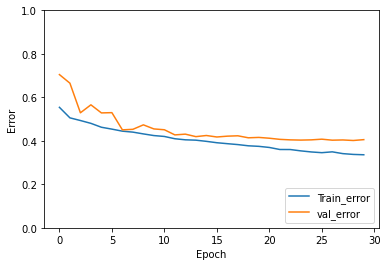

In [37]:
plt.plot(1 - np.array(history.history['accuracy']), label='Train_error')
plt.plot(1 - np.array(history.history['val_accuracy']), label = 'val_error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.ylim([0, 1])
plt.legend(loc='lower right')

From the graph we can see that training error decreased continously, while the validation error stopped at around 0.43 after 15 epochs. Now we are going to compare the artificially colored versions of the first 10 images in the test set.

In [38]:
prediction = model.predict(grayscale_test.reshape(1000, 32, 32, 1))

In [39]:
prediction = prediction.reshape(1000, 32, 32, k)

In [40]:
one_hot_encoded_test = one_hot_encoded_test.reshape(1000, 32, 32, k)

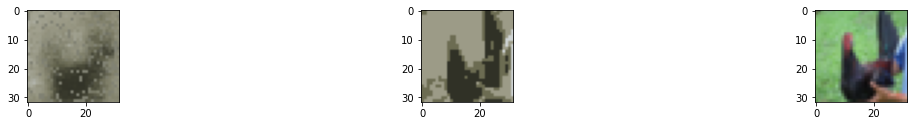

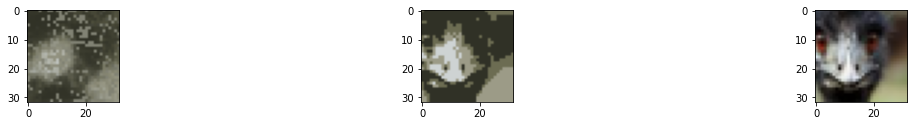

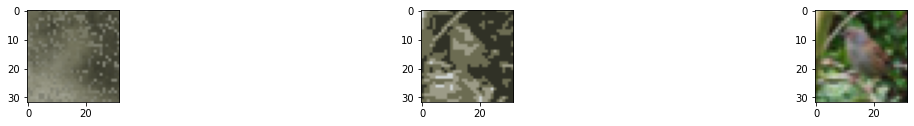

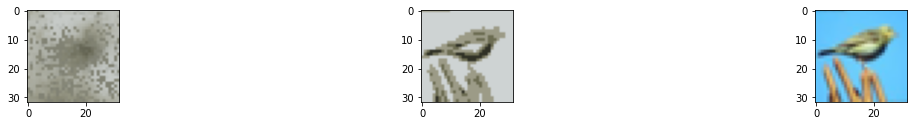

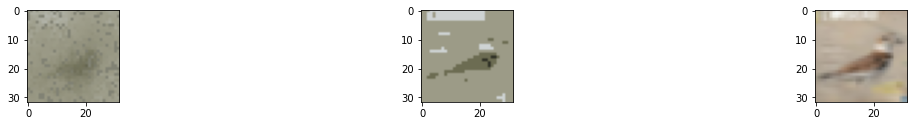

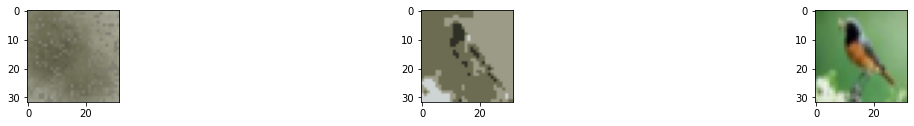

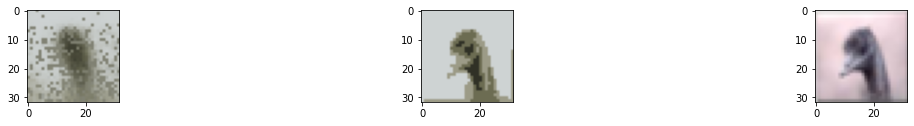

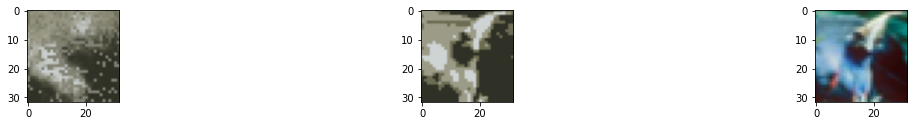

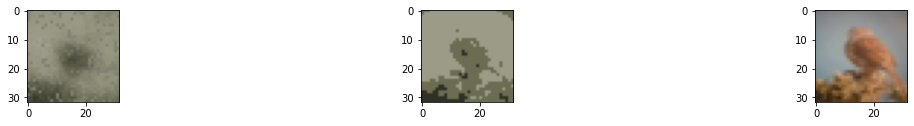

In [41]:
for i in range(0, 9):
    plt.figure(figsize=(20,20))
    plt.subplot(10, 3, 3*i+1)
    plt.imshow(np.dot(prediction[i], centroids).astype(np.uint8))
    plt.subplot(10, 3, 3*i+2)
    plt.imshow(np.dot(one_hot_encoded_test[i], centroids.astype(np.uint8)))
    plt.subplot(10, 3, 3*i+3)
    plt.imshow(X_test[i])
    plt.show()

I think it is similar to the original implementation without ResNet, or I did it wrong.